In [1]:
import os
os.chdir("/data/adv_geom/src/")
import sys
import json
import pickle
import random

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader

from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import (
    projected_gradient_descent,
)

from tqdm.notebook import tqdm

from datagen.synthetic.multiple.concentricspheres import ConcentricSpheres
from expB.myNNs import MTMLPwithNormalisation, MLP, MLPwithNormalisation
from expD.manifold_attack import pgd_l2_mfld_clf_attack, pgd_l2_mfld_dist_attack, pgd_l2_cls, pgd_dist, pgd_linf_rand


# Loading the Dataset

In [2]:
# data_dir = "/azuredrive/deepimage/data1/t-achetan/adv_geom_dumps/dumps/expD_distlearner_against_adv_eg/rdm_concspheres/rdm_concspheres_k2n500/data/"
# data_dir = "/data/k500n500_testsplits/"
data_dir = "/data/k100n100_testsplits/"


train_set, val_set, test_set = ConcentricSpheres.load_splits(data_dir)


shuffle = False
# batch_size = 1
batch_size = 512
num_workers = 8

dataloaders = {
    "train": DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size, num_workers=num_workers),
    "val": DataLoader(dataset=val_set, shuffle=False, batch_size=batch_size, num_workers=num_workers),
    "test": DataLoader(dataset=test_set, shuffle=False, batch_size=batch_size, num_workers=num_workers)
}





# Loading the model

Loading the standard classifier model to generate adversarial examples

In [43]:
input_size = 100
output_size = 2

hidden_sizes = [512] * 4

use_tanh = False
use_relu = False
weight_norm = False

cuda = 1
device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() and cuda is not None else "cpu")


# Standard Classifier model
# clf_init_wts = "/azuredrive/deepimage/data1/t-achetan/adv_geom_dumps/dumps/expD_distlearner_against_adv_eg/rdm_concspheres/rdm_concspheres_k2n500/8/models/ckpt.pth"
# clf_init_wts = "/azuredrive/deepimage/data1/t-achetan/adv_geom_dumps/dumps/expD_distlearner_against_adv_eg/rdm_concspheres/rdm_concspheres_k500n500_noninfdist/2/models/ckpt.pth"
clf_init_wts = "/azuredrive/deepimage/data1/t-achetan/adv_geom_dumps/dumps/expD_distlearner_against_adv_eg/rdm_concspheres/rdm_concspheres_k100n100_noninfdist/2/models/ckpt.pth"



# stdclf_model = MTMLPwithNormalisation(input_size=input_size,\
#          output_size=output_size, hidden_sizes=hidden_sizes,\
#          use_tanh=use_tanh, use_relu=use_relu, weight_norm=weight_norm)
# hidden_sizes = [1024] * 2
# stdclf_model = MLP(input_size=input_size,\
#          output_size=output_size, hidden_sizes=hidden_sizes,\
#          use_tanh=use_tanh, use_relu=use_relu, weight_norm=weight_norm)

hidden_sizes = [1024] * 2
stdclf_model = MLPwithNormalisation(input_size=input_size,\
         output_size=output_size, hidden_sizes=hidden_sizes,\
         use_tanh=use_tanh, use_relu=use_relu, weight_norm=weight_norm)


stdclf_model.load_state_dict(torch.load(clf_init_wts)["model_state_dict"])
stdclf_model.to(device)


# Distance Learner model
hidden_sizes = [512] * 4
distlearn_init_wts = "/azuredrive/deepimage/data1/t-achetan/adv_geom_dumps/dumps/expD_distlearner_against_adv_eg/rdm_concspheres/rdm_concspheres_k100n100_noninfdist/1/models/ckpt.pth"

distlearn_model = MTMLPwithNormalisation(input_size=input_size,\
         output_size=output_size, hidden_sizes=hidden_sizes,\
         use_tanh=use_tanh, use_relu=use_relu, weight_norm=weight_norm)


distlearn_model.load_state_dict(torch.load(distlearn_init_wts)["model_state_dict"])
distlearn_model.to(device)


num_neg = np.floor(dataloaders["test"].dataset.N / 2).astype(np.int64).item()
num_onmfld = dataloaders["test"].dataset.N - num_neg

stdclf_pred = torch.zeros(num_onmfld, 2)
dl_pred = torch.zeros(num_onmfld, 2)
stdclf_pred_ma = torch.zeros(num_onmfld, 2)
dl_pred_ma = torch.zeros(num_onmfld, 2)
stdclf_pred_ma_dl = torch.zeros(num_onmfld, 2)
dl_pred_ma_dl = torch.zeros(num_onmfld, 2)

all_deltas_ma = torch.zeros(num_onmfld, dataloaders["test"].dataset.n)
all_deltas_dl_ma = torch.zeros(num_onmfld, dataloaders["test"].dataset.n)


In [44]:
dl_model_dict = torch.load(distlearn_init_wts)
dl_model_dict["val_loss"]

3.448725501956876e-05

In [51]:
start = 0
end = 0
all_losses = list()
all_losses_dl = list()

for (i, batch) in tqdm(enumerate(dataloaders["test"])):
    
    inputs = batch["normed_points"]
    true_distances = batch["normed_actual_distances"]
    true_classes = batch["classes"]
    
    # experiment was performed on points 'exactly' on the manifold.
    # in our dataset, these points are those with class labels != 2
    inputs = inputs[true_classes != 2].to(device)
    true_distances = true_distances[true_classes != 2].to(device)
    true_classes = true_classes[true_classes != 2].to(device)
    end = start + inputs.shape[0]
    
    if inputs.shape[0] == 0:
        continue
    
    center = torch.from_numpy(test_set.fix_center).float().to(device)
#     deltas_ma, losses = pgd_l2_mfld_clf_attack(stdclf_model, inputs - center, true_classes, greedy=True)
#     deltas_ma_dl, losses_dl = pgd_l2_mfld_dist_attack(distlearn_model, inputs - center, true_distances, greedy=True)
#     deltas_ma, losses = pgd_l2_cls(stdclf_model, inputs, true_classes, epsilon=0.1, num_iter=200)
    adv_eg = projected_gradient_descent(stdclf_model,\
                           inputs, \
                           0.1, \
                           5e-3, \
                           100, \
                           2, y=true_classes)
    deltas_ma = adv_eg - inputs
    deltas_ma_dl, losses_dl = pgd_dist(distlearn_model, inputs, true_distances, epsilon=0.1, alpha=5e-3, num_iter=100, norm=2)
#     deltas_ma = all_deltas_ma[start:end].to(device)
#     all_losses.append(losses)
    all_losses_dl.append(losses_dl)
#     inputs_ma = inputs + deltas_ma
    inputs_ma = adv_eg
    inputs_ma_dl = inputs + deltas_ma_dl
    all_deltas_ma[start:end] = deltas_ma
    all_deltas_dl_ma[start:end] = deltas_ma_dl

#     x_fgm = fast_gradient_method(net, x, FLAGS.eps, np.inf)
#     x_pgd = projected_gradient_descent(net, x, FLAGS.eps, 0.01, 40, np.inf)
    with torch.no_grad():
        stdclf_model.eval()
        y_clf_pred = stdclf_model(inputs)
        y_clf_pred_ma = stdclf_model(inputs_ma)
        y_clf_pred_ma_dl = stdclf_model(inputs_ma_dl)
        
        distlearn_model.eval()
        y_dl_pred = distlearn_model(inputs)
        y_dl_pred_ma = distlearn_model(inputs_ma)
        y_dl_pred_ma_dl = distlearn_model(inputs_ma_dl)
        
        
    
    stdclf_model.train()
    distlearn_model.train()
    
    stdclf_pred[start:end] = y_clf_pred.detach().cpu()
    stdclf_pred_ma[start:end] = y_clf_pred_ma.detach().cpu()
    stdclf_pred_ma_dl[start:end] = y_clf_pred_ma_dl.detach().cpu()
    dl_pred[start:end] = y_dl_pred.detach().cpu()
    dl_pred_ma[start:end] = y_dl_pred_ma.detach().cpu()
    dl_pred_ma_dl[start:end] = y_dl_pred_ma_dl.detach().cpu()
    
    start = end
    


|          | 0/? [00:00<?, ?it/s]

In [52]:
stdclf_pred_ma[torch.max(stdclf_pred_ma, 1)[1] != test_set.class_labels[test_set.class_labels!=2]].shape

torch.Size([17276, 2])

In [35]:
dl_pred_ma_dl[torch.max(dl_pred_ma_dl, 1)[1] != test_set.class_labels[test_set.class_labels!=2]]




torch.Size([84508, 2])

In [63]:
dl_pred_labels_ma_dl.unique(return_counts=True)

(tensor([2]), tensor([100000]))

In [79]:
perturbed_pts_ma_dl = (test_set.normed_all_points[test_set.class_labels != 2] + all_deltas_dl_ma)
pairwise_dists_pert_to_mfld = torch.cdist(perturbed_pts_ma_dl, test_set.normed_all_points[test_set.class_labels != 2])
min_dist_pert_to_mfld = torch.min(pairwise_dists_pert_to_mfld, dim=1)

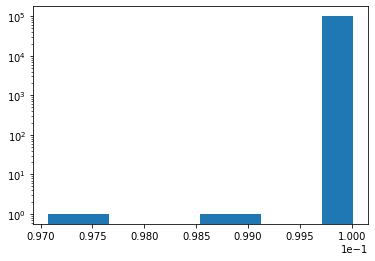

In [81]:
plt.hist(min_dist_pert_to_mfld.values.numpy(), log=True)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

(array([  730.,  1681.,  2721.,  7707., 11157., 11470.,  8328., 11357.,
        18305., 26544.]),
 array([0.09991051, 0.09991969, 0.09992887, 0.09993805, 0.09994724,
        0.09995642, 0.0999656 , 0.09997478, 0.09998397, 0.09999315,
        0.10000233], dtype=float32),
 <BarContainer object of 10 artists>)

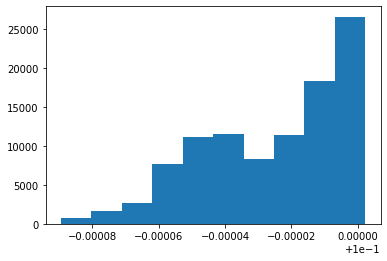

In [56]:
perturbed_pts_ma = (test_set.normed_all_points[test_set.class_labels != 2] + all_deltas_ma)
pairwise_dists_pert_to_mfld = torch.cdist(perturbed_pts_ma, test_set.normed_all_points[test_set.class_labels != 2])
min_dist_pert_to_mfld = torch.min(pairwise_dists_pert_to_mfld, dim=1)
plt.hist(min_dist_pert_to_mfld.values.numpy())

(array([50529.,  1805.,  6823.,  6335.,  4563.,  3644.,  8606., 11696.,
         5147.,   852.]),
 array([0.07426367, 0.13669978, 0.1991359 , 0.26157203, 0.32400814,
        0.38644427, 0.44888037, 0.5113165 , 0.57375264, 0.63618875,
        0.69862485], dtype=float32),
 <BarContainer object of 10 artists>)

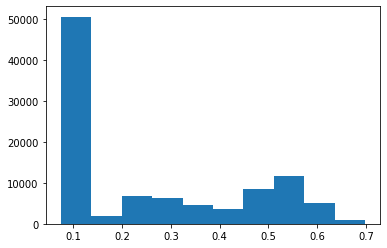

In [64]:
plt.hist(torch.min(dl_pred_ma_dl, axis=1).values.numpy())

(array([76104.,  8359.,  5113.,  3688.,  2594.,  1393.,  1057.,   344.,
          559.,   789.]),
 array([0.06420305, 0.10222142, 0.14023979, 0.17825815, 0.21627653,
        0.25429487, 0.29231325, 0.33033162, 0.36835   , 0.40636835,
        0.44438672], dtype=float32),
 <BarContainer object of 10 artists>)

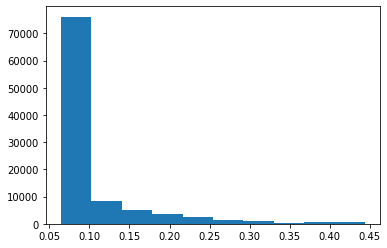

In [53]:
plt.hist(torch.min(dl_pred_ma, axis=1).values.numpy())

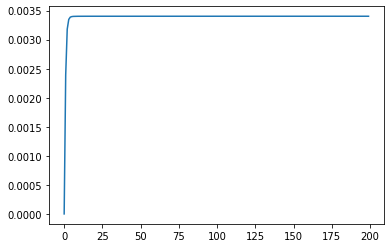

In [74]:
plt.plot(all_losses_dl[10])

In [72]:
len(all_losses[0])

200

In [66]:
dl_pred_ma[torch.min(dl_pred_ma, axis=1).values.numpy() < 0.07].shape

torch.Size([21350, 2])

In [31]:
stdclf_pred[0], stdclf_pred_ma[0], stdclf_pred_ma_dl[0]

(tensor([0.8233, 0.1654]), tensor([0.8804, 0.1098]), tensor([0.8964, 0.0931]))

In [28]:
test_set.normed_all_actual_distances[50000], dl_pred_ma_dl[0:1], dl_pred_ma[0:1]

(tensor([-7.7716e-16,  1.0000e+00]),
 tensor([[0.0864, 1.0000]]),
 tensor([[0.0753, 1.0000]]))

In [57]:
"dist_form_S1", torch.norm(test_set.normed_all_points[50000] + all_deltas_dl_ma[0] - test_set.normed_all_points[50000:100000], p=2, dim=1).min(), \
"dist_form_S2_off", torch.norm(test_set.normed_all_points[50000] + all_deltas_dl_ma[0] - test_set.normed_all_points[100000:150000], p=2, dim=1).min(), \
"dist_form_S1_off", torch.norm(test_set.normed_all_points[50000] + all_deltas_dl_ma[0] - test_set.normed_all_points[0:50000], p=2, dim=1).min(), \
"dist_form_S2", torch.norm(test_set.normed_all_points[50000] + all_deltas_dl_ma[0] - test_set.normed_all_points[150000:], p=2, dim=1).min()




('dist_form_S1',
 tensor(0.1000),
 'dist_form_S2_off',
 tensor(1.4668),
 'dist_form_S1_off',
 tensor(1.2769),
 'dist_form_S2',
 tensor(0.2386))

In [30]:
torch.norm(all_deltas_dl_ma[0], p=2)

tensor(0.0930)

In [29]:
torch.norm(test_set.normed_all_points[50000] + all_deltas_ma[0] - test_set.normed_all_points[50000:100000], p=2, dim=1).min(), \
torch.norm(test_set.normed_all_points[50000] + all_deltas_ma[0] - test_set.normed_all_points[100000:150000], p=2, dim=1).min(), \
torch.norm(test_set.normed_all_points[50000] + all_deltas_ma[0] - test_set.normed_all_points[0:50000], p=2, dim=1).min(), \
torch.norm(test_set.normed_all_points[50000] + all_deltas_ma[0] - test_set.normed_all_points[150000:], p=2, dim=1).min()


(tensor(0.1000), tensor(0.3677), tensor(0.0999), tensor(0.3712))

In [53]:
dist_of_adv_eg_from_inp = torch.cdist(test_set.normed_all_points[test_set.class_labels != 2] + all_deltas_dl_ma, test_set.normed_all_points[test_set.class_labels != 2], p=2)
min_dist_of_adv_eg = torch.min(dist_of_adv_eg_from_inp, dim=1)



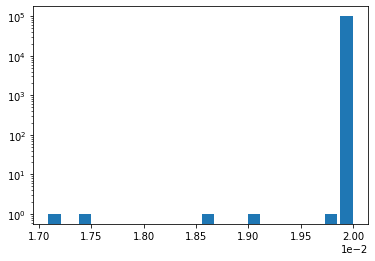

In [86]:
plt.hist(min_dist_of_adv_eg[0].numpy() - 0.08, log=True, bins=20, rwidth=0.8)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

In [59]:
np.linalg.norm(min_dist_of_adv_eg[0].numpy() - torch.min(dl_pred_ma_dl, dim=1)[0].numpy(), 2) / dl_pred_ma_dl.shape[0]

7.189647197723388e-05

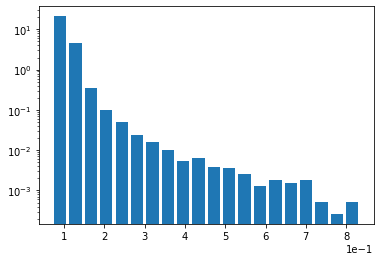

In [87]:
plt.hist(torch.min(dl_pred_ma_dl, dim=1)[0].numpy(), bins=20, log=True, rwidth=0.8, density=True)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

In [57]:
print("Std. Clf. on actual test set")
print(classification_report(test_set.class_labels[test_set.class_labels != 2], torch.max(stdclf_pred, 1)[1]))

print("Std. Clf. on perturbed test set by CLF attack")
print(classification_report(test_set.class_labels[test_set.class_labels != 2], torch.max(stdclf_pred_ma, 1)[1]))

print("Std. Clf. on perturbed test set by DL attack")
print(classification_report(test_set.class_labels[test_set.class_labels != 2], torch.max(stdclf_pred_ma_dl, 1)[1]))

print("Dist. Learner on actual test set")
dl_pred_labels = torch.min(dl_pred, 1)[1]

# dl_pred_labels[torch.min(dl_pred, 1)[0] > (test_set.D / test_set.norm_factor)] = 2
print(classification_report(test_set.class_labels[test_set.class_labels != 2], dl_pred_labels))

print("Dist. Learner on perturbed test set by CLF attack")
# dl_labels_on_perturbed_set = 
dl_pred_labels_ma = torch.min(dl_pred_ma, 1)[1]
# dl_pred_labels_ma[torch.min(dl_pred_ma, 1)[0] > 0.07] = 2

# dl_pred_labels_ma[torch.min(dl_pred_ma, 1)[0] > (test_set.D / test_set.norm_factor)] = 2
print(classification_report(test_set.class_labels[test_set.class_labels != 2], dl_pred_labels_ma))

print("Dist. Learner on perturbed test set by DL attack")
# dl_labels_on_perturbed_set = 
dl_pred_labels_ma_dl = torch.min(dl_pred_ma_dl, 1)[1]
dl_pred_labels_ma_dl[torch.min(dl_pred_ma_dl, 1)[0] > 0.12] = 2
# dl_pred_labels_ma_dl[torch.min(dl_pred_ma_dl, 1)[0] > (test_set.D / test_set.norm_factor)] = 2
print(classification_report(test_set.class_labels[test_set.class_labels != 2], dl_pred_labels_ma_dl))

Std. Clf. on actual test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50000
           1       1.00      1.00      1.00     50000

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

Std. Clf. on perturbed test set by CLF attack
              precision    recall  f1-score   support

           0       0.89      0.75      0.81     50000
           1       0.78      0.91      0.84     50000

    accuracy                           0.83    100000
   macro avg       0.84      0.83      0.83    100000
weighted avg       0.84      0.83      0.83    100000

Std. Clf. on perturbed test set by DL attack
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     50000
           1       0.94      0.98      0.96     50000

    accuracy                           0.96    100000
   macro

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


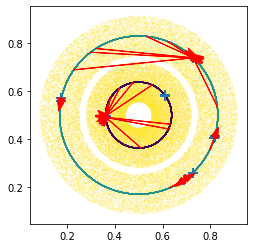

In [36]:
plt.scatter(test_set.normed_all_points.numpy()[:, 0], test_set.normed_all_points.numpy()[:, 1], c=test_set.class_labels, s=0.01)
on_mfld_pts = test_set.normed_all_points[test_set.class_labels != 2]
perturbed_pts = on_mfld_pts + all_deltas_ma[:50000]
plt.scatter(perturbed_pts.numpy()[:, 0], perturbed_pts.numpy()[:, 1], marker="+", s=100)
for i in random.sample(np.arange(on_mfld_pts.shape[0]).tolist(), 20):
    plt.arrow(on_mfld_pts[i, 0].numpy(), on_mfld_pts[i, 1].numpy(), all_deltas_ma[i, 0].numpy(), all_deltas_ma[i, 1].numpy(), head_width=0.03, color="red")
plt.gca().set_aspect('equal')



In [10]:
"perturbed over predictions:", dl_pred.min(1)[0][dl_pred_ma.min(1)[0] > (test_set.D / test_set.norm_factor)].shape, (test_set.D / test_set.norm_factor), \
"actual set over predictions", dl_pred.min(1)[0][dl_pred.min(1)[0] > (test_set.D / test_set.norm_factor)].shape

('perturbed over predictions:',
 torch.Size([2194]),
 0.075,
 'actual set over predictions',
 torch.Size([2377]))

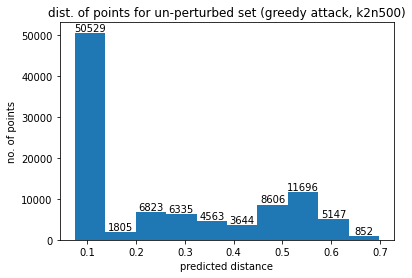

In [26]:
heights, xticks, _ = plt.hist(dl_pred_ma_dl.min(1)[0].numpy())
ax = plt.gca()
rects = ax.patches
labels = [str(int(i)) for i in heights]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.xlabel("predicted distance")
plt.ylabel("no. of points")
plt.title("dist. of points for un-perturbed set (greedy attack, k2n500)")
plt.show()


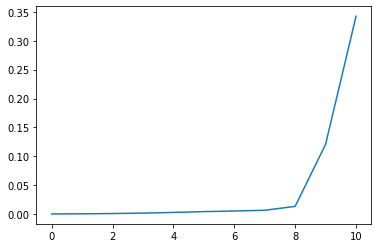

In [37]:
plt.plot(all_losses_dl[0])



(array([72880.,  7557., 11560.,  4709.,   887.,   245.,   174.,   443.,
         1391.,   154.]),
 array([  9. ,  27.5,  46. ,  64.5,  83. , 101.5, 120. , 138.5, 157. ,
        175.5, 194. ]),
 <BarContainer object of 10 artists>)

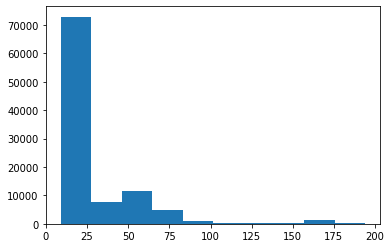

In [38]:
plt.hist([len(i) for i in all_losses_dl])

In [17]:
test_set.normed_all_actual_distances[test_set.class_labels != 2][:50000]

tensor([[-7.7716e-16,         inf],
        [ 2.2204e-16,         inf],
        [-1.1102e-16,         inf],
        ...,
        [-2.2204e-16,         inf],
        [-2.2204e-16,         inf],
        [ 0.0000e+00,         inf]])

In [22]:
torch.mean(torch.norm(test_set.normed_all_points[test_set.class_labels!=2], p=2, dim=1) - torch.norm(test_set.normed_all_points[test_set.class_labels!=2] + all_deltas_ma, p=2, dim=1))



tensor(-1.7893e-09)

In [17]:
all_deltas_ma

tensor([[-0.0352,  0.0756, -0.0603,  ...,  0.0299, -0.1090,  0.0153],
        [-0.0193,  0.0219,  0.0717,  ...,  0.0338,  0.0572,  0.0182],
        [ 0.0234, -0.0209, -0.0247,  ..., -0.0511,  0.1105, -0.1094],
        ...,
        [ 0.0943,  0.0209, -0.1480,  ...,  0.0438,  0.0069, -0.0217],
        [-0.0287,  0.0575, -0.0387,  ...,  0.0323,  0.1207, -0.0894],
        [ 0.0272, -0.0471, -0.0833,  ...,  0.0709,  0.0693, -0.1075]])

In [8]:
deltas, losses = pgd_l2_mfld_attack(stdclf_model, test_set.normed_all_points[test_set.class_labels!=2][:5].cuda() - test_set.fix_center, test_set.class_labels[test_set.class_labels!=2][:5].cuda())





TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
plt.plot(np.arange(1, 1001), np.mean(all_losses, axis=0), color="k")
plt.fill_between(np.arange(1, 1001), np.mean(all_losses, axis=0), np.min(all_losses, axis=0), np.max(all_losses, axis=0), color='red', alpha=0.4)

plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("avg. loss for each sample by on-mfld. pgd")

In [57]:
torch.norm(val_set.normed_all_points[val_set.class_labels != 2], p=2, dim=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.3000, 1.3000, 1.3000])

In [19]:
torch.norm(test_set.normed_all_points[test_set.class_labels != 2] + all_deltas_ma, p=2, dim=1).max()

tensor(1.3000)

In [63]:
dl_dump_dict = torch.load(distlearn_init_wts)

In [64]:
dl_dump_dict["loss"], dl_dump_dict["val_loss"], dl_dump_dict["epoch"], 

(1.9942767019988995e-07, 2.4784532030346236e-06, 996)

In [21]:
logits_fn = "/azuredrive/deepimage/data1/t-achetan/adv_geom_dumps/dumps/expD_distlearner_against_adv_eg/rdm_concspheres/rdm_concspheres_k2n500/7/logits/test/"


logits_specs = json.load(open(os.path.join(logits_fn, "specs.json")))
logits_specs

In [25]:
logits = torch.load(os.path.join(logits_fn, "logits.pt"))
targets = torch.load(os.path.join(logits_fn, "targets.pt"))

In [91]:
targets[:50000]

tensor([[0.0702,    inf],
        [0.0670,    inf],
        [0.0206,    inf],
        ...,
        [0.0341,    inf],
        [0.0843,    inf],
        [0.0217,    inf]])

In [136]:
np.linalg.norm(test_set.normed_all_points[test_set.class_labels != 2] + all_deltas_ma, ord=2, axis=1)

array([0.99999994, 1.        , 1.        , ..., 1.3000001 , 1.3       ,
       1.3000001 ], dtype=float32)

In [92]:
logits[:50000]

tensor([[0.0664, 0.0658],
        [0.0679, 0.0664],
        [0.0210, 0.0205],
        ...,
        [0.0346, 0.0341],
        [0.0872, 0.0868],
        [0.0204, 0.0200]])

In [93]:
logits[100000:150000]

tensor([[0.0668, 0.0663],
        [0.0688, 0.0669],
        [0.0215, 0.0207],
        ...,
        [0.0350, 0.0345],
        [0.0890, 0.0875],
        [0.0206, 0.0201]])

In [134]:
i = 32
np.linalg.norm(test_set.normed_all_points[i], ord=2), \
np.linalg.norm(test_set.normed_all_points[i] - test_set.normed_all_points[50000:100000], ord=2, axis=1).min(), \
np.linalg.norm(test_set.normed_all_points[i] - test_set.normed_all_points[150000:200000], ord=2, axis=1).min(), \
targets[i], \
logits[i]

(0.9996582,
 0.029228916,
 0.3021848,
 tensor([0.0292,    inf]),
 tensor([0.0301, 0.0295]))

In [126]:
test_set.normed_all_actual_distances[10]

tensor([0.0274,    inf])

(array([3.1515e+04, 1.0495e+04, 4.6980e+03, 1.9890e+03, 8.4300e+02,
        3.1300e+02, 1.1900e+02, 2.3000e+01, 3.0000e+00, 2.0000e+00]),
 array([0.        , 0.00249974, 0.00499947, 0.00749921, 0.00999894,
        0.01249868, 0.01499841, 0.01749815, 0.01999788, 0.02249762,
        0.02499735], dtype=float32),
 <BarContainer object of 10 artists>)

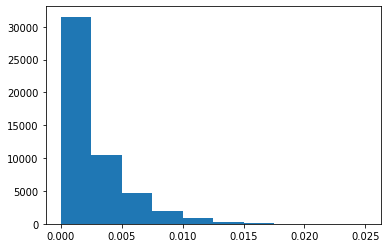

In [117]:
plt.hist(np.abs(np.linalg.norm(test_set.normed_all_points[100000:150000], ord=2, axis=1) - 1.3))

(array([5064., 4924., 5058., 4920., 4992., 5163., 4877., 4963., 4943.,
        5096.]),
 array([1.9954405e-06, 1.0001678e-02, 2.0001359e-02, 3.0001042e-02,
        4.0000726e-02, 5.0000407e-02, 6.0000088e-02, 6.9999769e-02,
        7.9999454e-02, 8.9999132e-02, 9.9998817e-02], dtype=float32),
 <BarContainer object of 10 artists>)

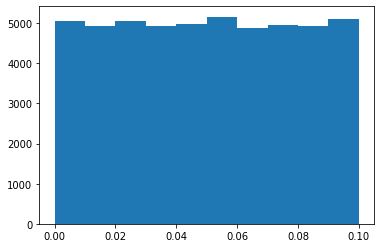

In [108]:
plt.hist(targets[100000:150000][:, 1].numpy())

In [104]:
test_set.max_norm, test_set.S1.genattrs.max_norm

(0.1, 0.1)

(array([5064., 4924., 5058., 4920., 4992., 5163., 4877., 4963., 4943.,
        5096.]),
 array([1.9954405e-06, 1.0001678e-02, 2.0001359e-02, 3.0001042e-02,
        4.0000726e-02, 5.0000407e-02, 6.0000088e-02, 6.9999769e-02,
        7.9999454e-02, 8.9999132e-02, 9.9998817e-02], dtype=float32),
 <BarContainer object of 10 artists>)

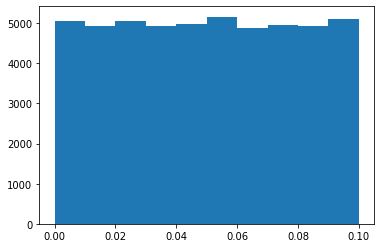

In [110]:
plt.hist(test_set.S2.genattrs.actual_distances[0:50000].numpy())

(array([8.0000e+00, 1.4200e+02, 1.3710e+03, 1.1610e+04, 2.7148e+04,
        7.2340e+03, 1.9940e+03, 4.3400e+02, 5.5000e+01, 4.0000e+00]),
 array([1.28253065, 1.28677735, 1.29102405, 1.29527076, 1.29951746,
        1.30376416, 1.30801086, 1.31225756, 1.31650426, 1.32075097,
        1.32499767]),
 <BarContainer object of 10 artists>)

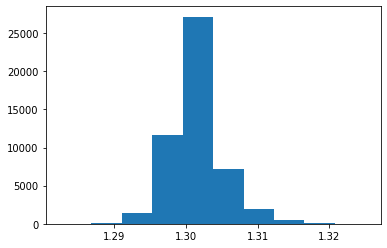

In [119]:
plt.hist(np.abs(np.linalg.norm(test_set.S2.genattrs.points_n[0:50000] - test_set.S2.specattrs.x_cn, ord=2, axis=1)))

In [94]:
targets[100000:150000]

tensor([[   inf, 0.0702],
        [   inf, 0.0670],
        [   inf, 0.0206],
        ...,
        [   inf, 0.0341],
        [   inf, 0.0843],
        [   inf, 0.0217]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.


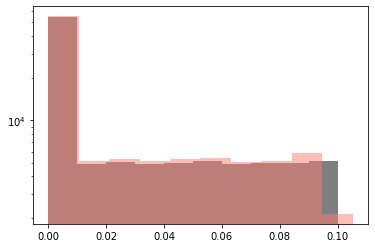

In [58]:
cls = 1
plt.hist(targets[test_set.all_actual_distances[:, cls] < np.inf][:, cls].numpy(), color="k", alpha=0.5)
plt.hist(logits[test_set.all_actual_distances[:, cls] < np.inf][:, cls].numpy(), color="salmon", alpha=0.5)
plt.yscale('log', nonposy='clip')

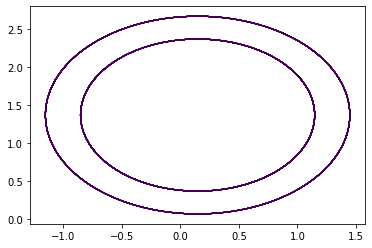

In [138]:
k_dim_points = (np.dot(np.linalg.inv(test_set.rotation), (test_set.normed_all_points - test_set.fix_center + test_set.anchor).T).T - test_set.translation)[:, :test_set.k]
plt.scatter(k_dim_points[test_set.class_labels != 2, 0], k_dim_points[test_set.class_labels != 2, 1], c=dl_pred.min(1)[1], s=0.01)








In [118]:
test_set.norm_factor

1

In [85]:
np.linalg.norm(np.mean(k_dim_points[test_set.class_labels != 2], axis=0) - test_set.x_ck, ord=2)

0.009844154893289303

In [86]:
test_set.D

0.07

(array([100000.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,    120.,  99880.]),
 array([0.98371222, 1.01748439, 1.05125657, 1.08502875, 1.11880092,
        1.1525731 , 1.18634528, 1.22011746, 1.25388963, 1.28766181,
        1.32143399]),
 <BarContainer object of 10 artists>)

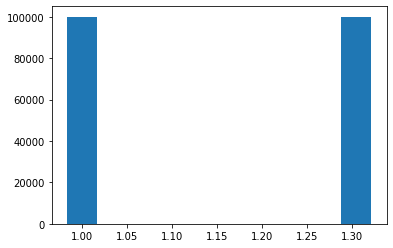

In [77]:
plt.hist(np.linalg.norm(k_dim_points - test_set.x_ck, ord=2, axis=1))

In [61]:
test_set.normed_all_points[test_set.class_labels != 2] + all_deltas_ma

tensor([[ 0.0259,  0.0775, -0.0299,  ..., -0.0421,  0.0387,  0.0680],
        [ 0.0123,  0.0934, -0.0276,  ..., -0.0597, -0.0046,  0.0808],
        [ 0.0288,  0.0696, -0.0290,  ..., -0.0352,  0.0485,  0.0629],
        ...,
        [-0.0220, -0.1004,  0.0367,  ...,  0.0643, -0.0383, -0.1001],
        [ 0.0455, -0.0164, -0.0145,  ...,  0.0255,  0.1037, -0.0181],
        [ 0.0232,  0.1139, -0.0323,  ..., -0.0749,  0.0232,  0.0996]])

In [68]:
(test_set.translation == val_set.translation).all()

True

In [37]:
stdclf_model.train()
start = 50000
end = 50020
deltas, losses = pgd_l2_cls(stdclf_model, test_set.normed_all_points[start:end].to(device), test_set.class_labels[start:end].to(device), epsilon=1e-3, alpha=5e-4, num_iter=100)
# deltas = pgd_linf_rand(stdclf_model, test_set.normed_all_points[start:end].to(device), test_set.class_labels[start:end].to(device), epsilon=1e-3, alpha=5e-4, num_iter=100, restarts=10)


adv_eg = projected_gradient_descent(stdclf_model,\
                           test_set.normed_all_points[start:end].to(device), \
                           0.08, \
                           5e-3, \
                           100, \
                           2, y=test_set.class_labels[start:end].to(device))

distlearn_model.train()
deltas_dl, losses_dl = pgd_dist(distlearn_model, test_set.normed_all_points[start:end].to(device), test_set.normed_all_actual_distances[start:end].to(device), norm=2, epsilon=8e-2, alpha=5e-3, num_iter=40)


with torch.no_grad():
    stdclf_model.eval()
    logits = stdclf_model((test_set.normed_all_points[start:end].to(device) + deltas.to(device))).detach().cpu()
    labels = test_set.class_labels[start:end]
    
    logits_cleverhans = stdclf_model(adv_eg).detach().cpu()
    
    distlearn_model.eval()
    logits_dl = distlearn_model((test_set.normed_all_points[start:end].to(device) + deltas_dl.to(device)))



In [38]:
np.sqrt(500) * 1e-3

0.022360679774997897

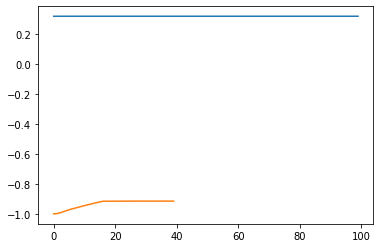

In [39]:
plt.plot(losses)
plt.plot(losses_dl)

In [40]:
logits_cleverhans

tensor([[0.6703, 0.3063],
        [0.8067, 0.1651],
        [0.8304, 0.2135],
        [0.6484, 0.2775],
        [0.9710, 0.0281],
        [0.9821, 0.0181],
        [0.7623, 0.1919],
        [0.3041, 0.7208],
        [0.9532, 0.0566],
        [0.9584, 0.0580],
        [0.8668, 0.1075],
        [0.9298, 0.0701],
        [0.7240, 0.2321],
        [0.9305, 0.0632],
        [0.8550, 0.1584],
        [0.8309, 0.1832],
        [0.5534, 0.4194],
        [0.9127, 0.1296],
        [0.7099, 0.3743],
        [0.9179, 0.0891]])

In [41]:
logits

tensor([[0.9783, 0.0190],
        [0.9909, 0.0073],
        [0.9913, 0.0100],
        [0.9822, 0.0135],
        [0.9977, 0.0021],
        [0.9986, 0.0013],
        [0.9879, 0.0099],
        [0.9363, 0.0725],
        [0.9971, 0.0033],
        [0.9969, 0.0041],
        [0.9926, 0.0065],
        [0.9961, 0.0040],
        [0.9896, 0.0082],
        [0.9953, 0.0040],
        [0.9926, 0.0069],
        [0.9938, 0.0074],
        [0.9741, 0.0275],
        [0.9949, 0.0080],
        [0.9874, 0.0142],
        [0.9947, 0.0050]])

In [42]:
logits_dl

tensor([[0.0851, 1.0000],
        [0.0897, 1.0000],
        [0.0848, 1.0000],
        [0.0772, 1.0000],
        [0.1103, 0.9999],
        [0.0816, 0.9996],
        [0.0920, 1.0000],
        [0.0848, 1.0000],
        [0.0842, 1.0000],
        [0.0947, 1.0000],
        [0.0945, 1.0000],
        [0.0888, 1.0000],
        [0.0841, 1.0000],
        [0.0765, 1.0000],
        [0.0887, 1.0000],
        [0.0821, 1.0000],
        [0.0766, 1.0000],
        [0.0889, 1.0000],
        [0.0820, 1.0000],
        [0.0868, 1.0000]], device='cuda:1')

In [98]:
torch.norm(adv_eg.cpu() - test_set.normed_all_points[start:end], p=2, dim=1)

tensor([0.0883, 0.0888, 0.0885, 0.0888, 0.0891, 0.0886, 0.0883, 0.0890, 0.0889,
        0.0886, 0.0888, 0.0890, 0.0888, 0.0885, 0.0885, 0.0886, 0.0882, 0.0882,
        0.0887, 0.0885], grad_fn=<NormBackward1>)

In [118]:
dist_mat1 = torch.cdist(test_set.normed_all_points[start:end] + deltas_dl.detach().cpu(), test_set.normed_all_points[test_set.class_labels == 0])



In [119]:
torch.min(dist_mat1, axis=1)

torch.return_types.min(
values=tensor([0.0223, 0.0223, 0.0223, 0.0223, 0.0224, 0.0223, 0.0223, 0.0223, 0.0223,
        0.0223, 0.0224, 0.0223, 0.0223, 0.0224, 0.0223, 0.0223, 0.0223, 0.0223,
        0.0223, 0.0224]),
indices=tensor([    0, 30783, 45698, 41548,  9065,  2477, 46035, 25177, 27383,     9,
        42279, 46650, 25723,    13, 13841,  3178, 17540, 11921, 19704, 47286]))

In [32]:
dist_mat2 = torch.cdist(test_set.normed_all_points[start:end] + deltas_dl.detach().cpu(), test_set.normed_all_points[test_set.class_labels == 0])
torch.min(dist_mat2, axis=1)

torch.return_types.min(
values=tensor([0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500, 0.0500,
        0.0500, 0.0500]),
indices=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]))

In [88]:
dist_mat3 = torch.cdist(adv_eg.detach().cpu(), test_set.normed_all_points[test_set.class_labels == 0])
torch.min(dist_mat3, axis=1)

torch.return_types.min(
values=tensor([0.0883, 0.0884, 0.0885, 0.0888, 0.0888, 0.0886, 0.0883, 0.0889, 0.0887,
        0.0885, 0.0889, 0.0890, 0.0891, 0.0885, 0.0883, 0.0893, 0.0886, 0.0883,
        0.0887, 0.0883]),
indices=tensor([39576, 16256, 21792, 20479, 47912, 26876, 15087, 22179, 30630, 23528,
        26506, 43444, 40812, 34786, 20113, 40472, 19847, 31484, 10152, 11464]))

In [21]:
stdclf_model

MLPwithNormalisation(
  (layers): Sequential(
    (fcn-0): Linear(in_features=500, out_features=1024, bias=True)
    (bn-0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (relu-0): ReLU()
    (fcn-1): Linear(in_features=1024, out_features=1024, bias=True)
    (bn-1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (relu-1): ReLU()
    (fcn-2): Linear(in_features=1024, out_features=2, bias=True)
    (sigmoid-2): Sigmoid()
  )
)

In [69]:
t = torch.rand(5, 5)

In [73]:
t.norm(p=np.inf, dim=1).reshape(-1, 1)

tensor([[0.8710],
        [0.8655],
        [0.9102],
        [0.6136],
        [0.8012]])

In [71]:
t

tensor([[0.2434, 0.3153, 0.0371, 0.4137, 0.8710],
        [0.1922, 0.3899, 0.6851, 0.8655, 0.6580],
        [0.7143, 0.1528, 0.2833, 0.9102, 0.5503],
        [0.0723, 0.6136, 0.5882, 0.3322, 0.1040],
        [0.2322, 0.2919, 0.8012, 0.0481, 0.2248]])

In [77]:
dataloaders["test"].dataset.class_labels[dataloaders["test"].dataset.class_labels != 2].max().item()

1

In [88]:
import seaborn as sns

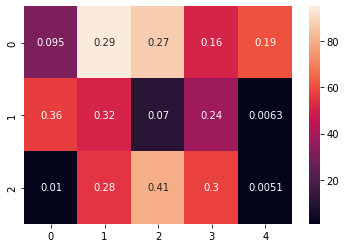

In [100]:
tmp = np.random.randint(0, 100, size=(3, 5))
sns.heatmap(tmp, annot=tmp / tmp.sum(axis=1).reshape(-1, 1))
plt.show()

In [102]:
test_set.

0.1